In [1]:
# Parsing ascii files from the eyelink into eye position and data table files
# Clara Kuper, September 2020
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import random as random
import ipywidgets as widgets
from my_funcs import get_d_prime
from my_funcs import get_p_in
from scipy import stats
from sklearn.linear_model import LinearRegression
import math
import os
import re
import warnings
warnings.filterwarnings("ignore")

# define relevant paths
path_clean = '../2_cleaned/'
path_figs = '../3_figures/'

#load files
sac = pd.read_csv(path_clean+'em_cleaned_reverse.csv', sep = ',')
df = pd.read_csv(path_clean+'df_cleaned_reverse.csv', sep = ',')
info = pd.read_csv('../0-1_raw/visual.txt', sep = '\t')

In [2]:
# Define some important column names:

# probability of a hit, computed at each target taking into account previous targets from the trial (between 0 and 1)
# p_in_names = ['pi_pos01', 'pi_pos02', 'pi_pos03', 'pi_pos04', 'pi_pos05', 'pi_pos06']
# probability of a hit - computed at each target ignoring previous targets (between 0 and 1)
p_in_single_names = ['pi_single_pos01', 'pi_single_pos02', 'pi_single_pos03', 'pi_single_pos04', 'pi_single_pos05', 'pi_single_pos06']
# probability of a hit - computed at each target ignoring previous targets (between 0 and 1)
p_in_names = ['pi_single_pos01', 'pi_single_pos02', 'pi_single_pos03', 'pi_single_pos04', 'pi_single_pos05', 'pi_single_pos06']

# probability of the shown target to be inside the goal (between 0 and 1)
p_tar_names = ['p_tar01', 'p_tar02','p_tar03', 'p_tar04', 'p_tar05', 'p_tar06']
# the position of the target in degree relative to the attacker (between 8 and -8)
p_dva_names = ['posSet_1', 'posSet_2','posSet_3', 'posSet_4', 'posSet_5', 'posSet_6']
# "evidence" the absolute distance from a certain value (between 0 and 0.5)
ev_names = ['ev_pos01','ev_pos02','ev_pos03','ev_pos04','ev_pos05','ev_pos06']
# how much of the goal was covered at the given tp (between 0 and 1)
goal_cover_names = ['g_cover01','g_cover02','g_cover03','g_cover04','g_cover05','g_cover06']
# the difference to the correct anwer
p_hitGoal_names = ['p_hitGoal01','p_hitGoal02','p_hitGoal03','p_hitGoal04','p_hitGoal05','p_hitGoal06']
# the difference to the actual answer
p_goResp_names = ['p_goResp01','p_goResp02','p_goResp03','p_goResp04','p_goResp05','p_goResp06']
# time values
time_names = ['tt_1', 'tt_2','tt_3', 'tt_4','tt_5', 'tt_6']


#rev_p_in_names = ['rev_pi_pos0', 'rev_pi_pos1', 'rev_pi_pos2', 'rev_pi_pos3', 'rev_pi_pos4']
rev_p_in_single_names = ['rev_pi_sing1', 'rev_pi_sing2', 'rev_pi_sing3', 'rev_pi_sing4', 'rev_pi_sing5', 'rev_pi_sing6']
rev_p_in_names = ['rev_pi_sing1', 'rev_pi_sing2', 'rev_pi_sing3', 'rev_pi_sing4', 'rev_pi_sing5', 'rev_pi_sing6']

rev_p_tar_names = ['rev_p_tar0', 'rev_p_tar1', 'rev_p_tar2', 'rev_p_tar3', 'rev_p_tar4']
rev_d_dva_names = ['rev_posSet_0', 'rev_posSet_1', 'rev_posSet_2', 'rev_posSet_3', 'rev_posSet_4']
rev_ev_names = ['rev_ev_pos0', 'rev_ev_pos1', 'rev_ev_pos2', 'rev_ev_pos3', 'rev_ev_pos4']
rev_goal_cover_names = ['rev_g_cover0', 'rev_g_cover1', 'rev_g_cover2', 'rev_g_cover3', 'rev_g_cover4']
rev_p_hitGoal_names = ['rev_p_hitGoal0', 'rev_p_hitGoal1', 'rev_p_hitGoal2', 'rev_p_hitGoal3', 'rev_p_hitGoal4']
rev_p_goResp_names = ['rev_p_goResp0', 'rev_p_goResp1', 'rev_p_goResp2', 'rev_p_goResp3', 'rev_p_goResp4']

In [3]:
#  save an answer (1 for correct, 0 for incorrect)
df['answer'] = 1-(np.abs(df.goResp - df.hitGoal))

# define some sub datasets

go_df = df[df.goResp == 1]
nogo_df = df[df.goResp == 0]

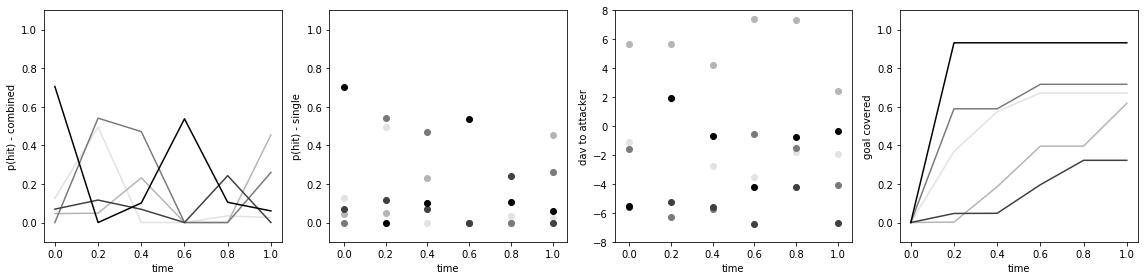

In [4]:
# just plot some of the p(in) for fun

rand_p = np.random.choice(df.index,5)
p_plot, p_axs = plt.subplots(1,4, figsize = (16,4))

cmap = plt.cm.Greys(np.linspace(0.2,1,len(rand_p)))

for p,c in zip(rand_p,cmap):
    p_axs[0].plot(np.linspace(0,1,len(p_in_names)),df.loc[p,p_in_names], color = c)
    p_axs[1].scatter(np.linspace(0,1,len(p_in_single_names)),df.loc[p,p_in_single_names], color = c)
    p_axs[2].scatter(np.linspace(0,1,len(p_dva_names)),df.loc[p,p_dva_names], color = c)
    p_axs[3].plot(np.linspace(0,1,len(goal_cover_names)),df.loc[p,goal_cover_names], color = c)
p_axs[0].set_xlabel('time')
p_axs[0].set_ylabel('p(hit) - combined')
p_axs[0].set_ylim(-0.1,1.1)
p_axs[1].set_xlabel('time')
p_axs[1].set_ylabel('p(hit) - single')
p_axs[1].set_ylim(-0.1,1.1)
p_axs[2].set_xlabel('time')
p_axs[2].set_ylabel('dav to attacker')
p_axs[2].set_ylim(-8,8)
p_axs[3].set_xlabel('time')
p_axs[3].set_ylabel('goal covered')
p_axs[3].set_ylim(-0.1,1.1)
plt.tight_layout()

#plt.savefig(path_figs+'p_in4.png')

Text(0.5, 0, 'time (s)')

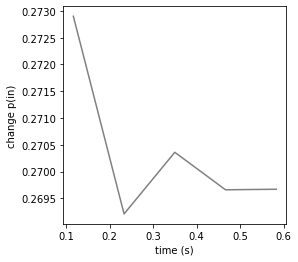

In [5]:
fig_ch , axs_ch = plt.subplots(1,1, figsize = [4,4])

axs_ch.plot(np.linspace(0,.7,7)[1:6],np.mean(abs(np.diff(df.loc[:,p_in_names])),axis = 0), color = 'grey')
axs_ch.set_ylabel('change p(in)')
axs_ch.set_xlabel('time (s)')

#plt.savefig(path_figs + 'changes_time_NS1.png')

Text(0.5, 0, 'time (s)')

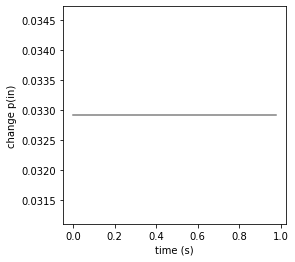

In [6]:
new_p = pd.read_csv('../../1_Simulations/Sim_NoiseStrike1')

fig_ch , axs_ch = plt.subplots(1,1, figsize = [4,4])

axs_ch.plot(np.linspace(0,1.1,10)[:9],np.mean(abs(np.diff(new_p.loc[:,['pi_pos01', 'pi_pos02', 'pi_pos03', 'pi_pos04', 'pi_pos05', 'pi_pos06', 'pi_pos07', 'pi_pos08', 'pi_pos09', 'pi_pos10']])),axis = 0), color = 'grey')
axs_ch.set_ylabel('change p(in)')
axs_ch.set_xlabel('time (s)')

#fig_ch.savefig(path_figs + 'changes_time_NS2.png')

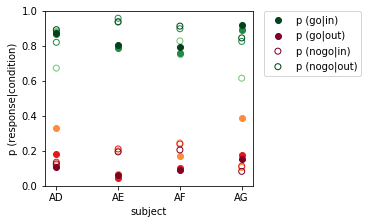

In [7]:
# step 1 describe behaviour
# plot performance as % correct answers per participant, 
# plot p(go|in), p(no|out)


fig1 = plt.figure(constrained_layout = True, figsize = (5,3))
gs = fig1.add_gridspec(2, 2)
f1_ax2 = fig1.add_subplot(gs[0:, 0:])

def given(cond, gcond, key, gkey):
    n_gcond = sum(gcond == gkey)
    n_cond_gcond = len(cond[(cond == key) & (gcond == gkey)])
    
    return n_cond_gcond/n_gcond

p_names = ['p_in|in','p_in|out','p_out|in','p_out|out']

color_cor = plt.cm.Greens(np.linspace(0,1,5))[2:]
color_ico = plt.cm.YlOrRd(np.linspace(0,1,5))[2:]

for session, c_c, c_i in zip(np.unique(df.session),color_cor, color_ico):
    
    ses_dat = df[df.session == session]
    by_sub = ses_dat.groupby('subject')
    sub_sum = by_sub.describe()

    p_given = pd.DataFrame(np.zeros((len(sub_sum.index),4)), index = sub_sum.index, columns = p_names)


    for sub in sub_sum.index:

        pin_in = given(ses_dat.goResp[ses_dat.subject == sub], ses_dat.hitGoal[ses_dat.subject == sub], 1,1)
        pin_out = given(ses_dat.goResp[ses_dat.subject == sub], ses_dat.hitGoal[ses_dat.subject == sub], 1,0)
        pout_in = given(ses_dat.goResp[ses_dat.subject == sub], ses_dat.hitGoal[ses_dat.subject == sub], 0,1)
        pout_out = given(ses_dat.goResp[ses_dat.subject == sub], ses_dat.hitGoal[ses_dat.subject == sub], 0,0)

        p_given['p_in|in'][sub] = pin_in
        p_given['p_in|out'][sub] = pin_out
        p_given['p_out|in'][sub] = pout_in
        p_given['p_out|out'][sub] = pout_out

    a = f1_ax2.scatter(p_given.index,  p_given['p_in|in'], label = 'in|in', facecolors=c_c, edgecolors=c_c)
    b = f1_ax2.scatter(p_given.index,  p_given['p_in|out'], label = 'in|out', facecolors=c_i, edgecolors=c_i)
    c = f1_ax2.scatter(p_given.index,  p_given['p_out|in'], label = 'out|in', facecolors='None', edgecolors=c_i)
    d = f1_ax2.scatter(p_given.index,  p_given['p_out|out'], label = 'out|out', facecolors='None', edgecolors=c_c)

    f1_ax2.set_ylim(0,1)
f1_ax2.set_xlabel('subject') 
f1_ax2.set_ylabel('p (response|condition)')
f1_ax2.legend([a,b,c,d], ['p (go|in)', 'p (go|out)', 'p (nogo|in)', 'p (nogo|out)'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

#plt.savefig(path_figs+'p_resp_cond.png')

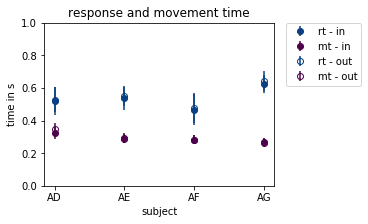

In [8]:
# step 1.2 describe reaction and movement times

figrt = plt.figure(constrained_layout = True, figsize = (5,3))
gs = figrt.add_gridspec(2, 2)

#frt_ax1 = figrt.add_subplot(gs[0:, :1])
frt_ax2 = figrt.add_subplot(gs[0:, 0:])


color_mt = plt.cm.BuPu(np.linspace(0,1,5))[2:]
color_rt = plt.cm.GnBu(np.linspace(0,1,5))[2:]

#for session, c_mt, c_rt in zip(np.unique(df.session),color_mt, color_rt):
    #ses_dat = df[df.session == session]
    
by_sub = df.groupby('subject')
sub_sum = by_sub.describe()

    #frt_ax1.errorbar(sub_sum.index,sub_sum.rea_time['mean'],sub_sum.rea_time['std'], label = 'rt',fmt='o')
    #frt_ax1.errorbar(sub_sum.index,sub_sum.mov_time['mean'],sub_sum.mov_time['std'], label = 'mt',fmt='o')
    #frt_ax1.set_title('reaction times and movement duration')
    #frt_ax1.set_ylim(0,1)


p_names = ['go|in','go|out','nogo|in','nogo|out']

rts = pd.DataFrame(np.zeros((len(sub_sum.index),len(p_names))), index = sub_sum.index, columns = p_names)
rt_e = pd.DataFrame(np.zeros((len(sub_sum.index),len(p_names))), index = sub_sum.index, columns = p_names)
mts = pd.DataFrame(np.zeros((len(sub_sum.index),len(p_names))), index = sub_sum.index, columns = p_names)
mt_e = pd.DataFrame(np.zeros((len(sub_sum.index),len(p_names))), index = sub_sum.index, columns = p_names)

for sub in sub_sum.index:
    go_in = df[((df.subject == sub)&(df.hitGoal==1))&(df.goResp == 1)]
    go_out = df[((df.subject == sub)&(df.hitGoal==0))&(df.goResp == 1)]
    nogo_in = df[((df.subject == sub)&(df.hitGoal==1))&(df.goResp == 0)]
    nogo_out = df[((df.subject == sub)&(df.hitGoal==0))&(df.goResp == 0)]

    rts['go|in'][sub] = np.mean(go_in.rea_time)
    rts['go|out'][sub] = np.mean(go_out.rea_time)
    rts['nogo|in'][sub] = np.mean(nogo_in.rea_time)
    rts['nogo|out'][sub] = np.mean(nogo_out.rea_time)

    rt_e['go|in'][sub] = np.std(go_in.rea_time)
    rt_e['go|out'][sub] = np.std(go_out.rea_time)
    rt_e['nogo|in'][sub] = np.std(nogo_in.rea_time)
    rt_e['nogo|out'][sub] = np.std(nogo_out.rea_time)

    mts['go|in'][sub] = np.mean(go_in.mov_time)
    mts['go|out'][sub] = np.mean(go_out.mov_time)
    mts['nogo|in'][sub] = np.mean(nogo_in.mov_time)
    mts['nogo|out'][sub] = np.mean(nogo_out.mov_time)

    mt_e['go|in'][sub] = np.std(go_in.mov_time)
    mt_e['go|out'][sub] = np.std(go_out.mov_time)
    mt_e['nogo|in'][sub] = np.std(nogo_in.mov_time)
    mt_e['nogo|out'][sub] = np.std(nogo_out.mov_time)

a = frt_ax2.errorbar(rts.index, rts['go|in'], rt_e['go|in'], label = 'rt_in', fmt='o', color = color_rt[2])
b = frt_ax2.errorbar(mts.index, mts['go|in'], mt_e['go|in'], label = 'mt_in', fmt='o', color = color_mt[2])
frt_ax2.set_ylim(0,1)
c = frt_ax2.errorbar(rts.index, rts['go|out'], rt_e['go|out'], label = 'rt_out', fmt='o', color = color_rt[2],mfc='none')
d = frt_ax2.errorbar(mts.index, mts['go|out'], mt_e['go|out'], label = 'mt_out', fmt='o', color = color_mt[2],mfc='none')
frt_ax2.set_title('response and movement time')
frt_ax2.set_ylim(0,1)
frt_ax2.legend()
frt_ax2.set_xlabel('subject') 
frt_ax2.set_ylabel('time in s')
frt_ax2.legend([a,b,c,d], ['rt - in', 'mt - in', 'rt - out', 'mt - out'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

#plt.savefig(path_figs+'rt_mt.png')

Performance is very high (probably too high). There is no clear difference between go- and nogo performance. Reaction times don't seem to differ between correct and incorrect responses, the same seems to be true for movement duration. It seems like longer reaction times are associated with shorter movement duration.

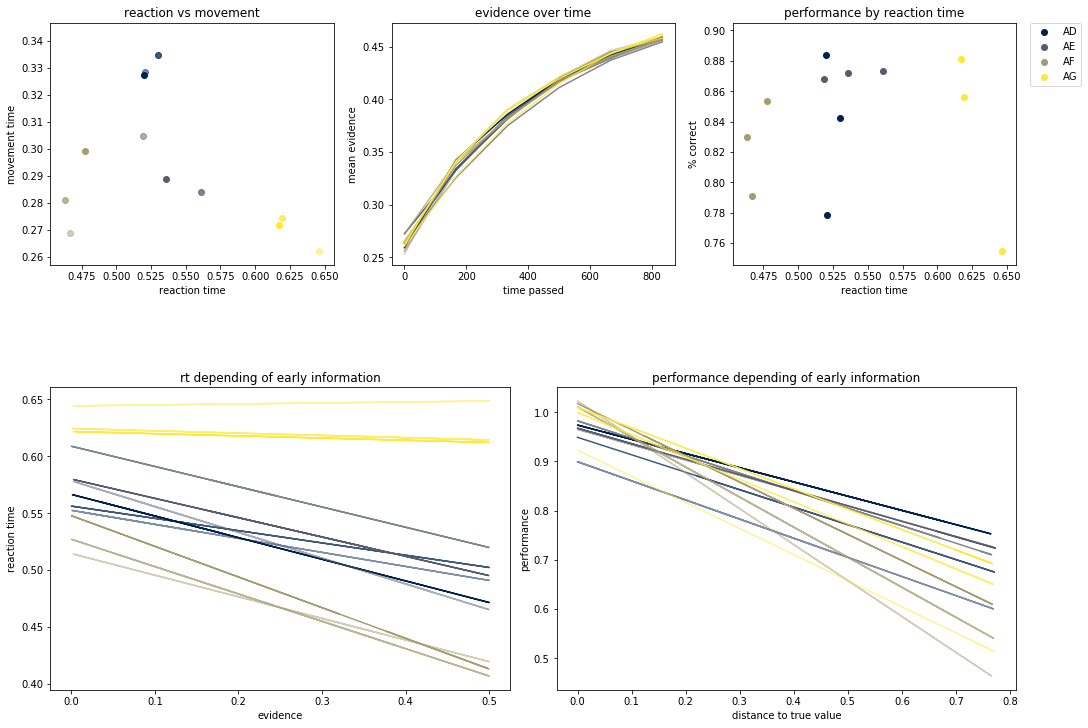

In [9]:
# How do reaction times vary/does the movement time depend on the presented information
fig2= plt.figure(constrained_layout = True, figsize = (15,10))
gs2 = fig2.add_gridspec(10, 6)

#fig_rt_p, axs_rt_p = plt.subplots(1, figsize = (10,3))

f2_axs1 = fig2.add_subplot(gs2[0:4, 0:2])
f2_axs2 = fig2.add_subplot(gs2[0:4, 2:4])
f2_axs3 = fig2.add_subplot(gs2[0:4, 4:6])
f2_axs4 = fig2.add_subplot(gs2[5:10, 0:3])
f2_axs5 = fig2.add_subplot(gs2[5:10, 3:6])


f2_axs1.set_title('reaction vs movement')
f2_axs1.set_xlabel('reaction time')
f2_axs1.set_ylabel('movement time')

f2_axs2.set_title('evidence over time')
f2_axs2.set_xlabel('time passed')
f2_axs2.set_ylabel('mean evidence')

f2_axs3.set_title('performance by reaction time')
f2_axs3.set_xlabel('reaction time')
f2_axs3.set_ylabel('% correct')

f2_axs4.set_title('rt depending of early information')
f2_axs4.set_xlabel('evidence')
f2_axs4.set_ylabel('reaction time')

f2_axs5.set_title('performance depending of early information')
f2_axs5.set_xlabel('distance to true value')
f2_axs5.set_ylabel('performance')

subjects = np.unique(df.subject)

color = plt.cm.cividis(np.linspace(0,1,len(subjects)))

for idx, sub, c in zip(np.linspace(0,1,len(subjects)),subjects, color):
    rt_sub = []
    mt_sub = []
    perf_sub = []
    
    alpha = np.linspace(0.5,1,len(np.unique(df[df.subject == sub].session)))
    for ses, a in zip(np.unique(df[df.subject == sub].session),alpha):
        
        # how does the movement time depend on the reaction time
        rt_sub.append(np.mean(df[(df.subject ==sub) & (df.session == ses)].rea_time))
        mt_sub.append(np.mean(df[(df.subject ==sub) & (df.session == ses)].mov_time))
        
        
        # how does the information depend on the movement time
        f2_axs2.plot(np.mean(df.loc[(df.subject ==sub) & (df.session == ses),time_names]), np.mean(df[(df.subject ==sub) & (df.session == ses)].loc[:,ev_names[:6]]),label = sub, color =c , alpha = a)

        
        # how does the movement time depend on the information in the first 3 windows
        #X = np.mean(df[(df.subject ==sub) & (df.session == ses)].loc[:,ev_names[:1]].values, axis =1)
        #y = df[(df.subject ==sub) & (df.session == ses)].rea_time
        #f2_axs4.scatter(X,y, label = sub)
        #f2_axs4.legend()
        
        # fit a linear regression
        X_go = np.mean(go_df[(df.subject ==sub) & (go_df.session == ses)].loc[:,ev_names[:1]].values, axis =1)
        y_go = go_df[(df.subject ==sub) & (go_df.session == ses)].rea_time
        reg =  LinearRegression().fit(X_go.reshape(-1,1), y_go)
        f2_axs4.plot(X_go, reg.coef_*X_go+reg.intercept_, color =c , alpha = a)
        
        
        # how does performance time depend on the information in the first 3 windows
        X_p = np.mean(df[(df.subject ==sub) & (df.session == ses)].loc[:,p_hitGoal_names[:1]].values, axis =1)
        y_p = df[(df.subject ==sub) & (df.session == ses)].answer
        
        # fit a linear regression
        reg_p =  LinearRegression().fit(X_p.reshape(-1,1), y_p)
        f2_axs5.plot(X_p, reg_p.coef_*X_p+reg_p.intercept_, color =c , alpha = a)
        
        # how does the performance depend on reaction time
        perf_sub.append(np.mean(df[(df.subject ==sub) & (df.session == ses)].answer))
        
        f2_axs1.scatter(np.mean(df[(df.subject ==sub) & (df.session == ses)].rea_time),np.mean(df[(df.subject ==sub) & (df.session == ses)].mov_time), label=sub,  color =c , alpha = a)
        
    f2_axs3.scatter(rt_sub, perf_sub, label=sub, color =c , alpha = a) 
    
    
    
    
#f2_axs1.legend(legend([a,b,c,d], ['rt - in', 'mt - in', 'rt - out', 'mt - out'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.))
f2_axs3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);


#fig2.savefig(path_figs+'rt_early_inf')
#plt.savefig(path_figs+'detailed_rts_movements.png')
        

Here, we can confirm that there is a trend of longer reaction times with shorter movement times. Evidence develops evenly for sessions from the same category. However, the first three sessions look odd....

The correlation between performance and reaction time is less clear. 

When the first time window was very informative, reaction times were shorter.
When early time windows were missleading, the responses were wrong.

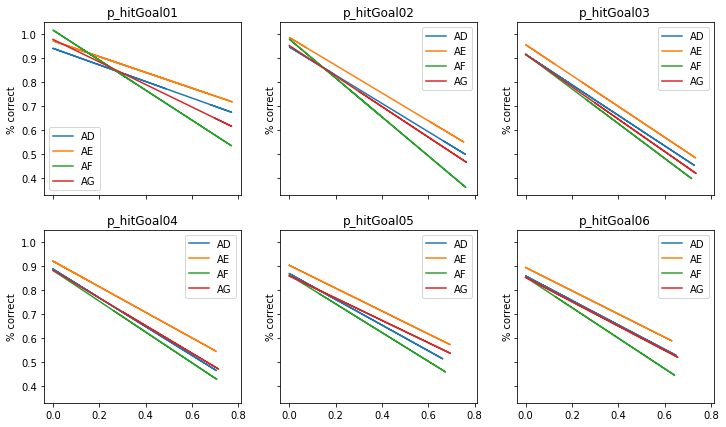

In [10]:
# exploration of performance_information correlation

fig_perf_dist, axs_pd = plt.subplots(2,3, figsize = (12,7), sharex= True, sharey = True)
idx = 0


tn = p_hitGoal_names

for tw in tn:
    for sub in np.unique(df.subject):
        # how does performance time depend on the information in any given time window
        X = df[(df.subject ==sub)].loc[:,tw].values
        y = df[(df.subject ==sub)].answer

        # fit a linear regression
        reg =  LinearRegression().fit(X.reshape(-1,1), y)
        axs_pd.flatten()[idx].plot(X, reg.coef_*X+reg.intercept_, label = sub)
        axs_pd.flatten()[idx].set_title(tw)
        axs_pd.flatten()[idx].legend()
        axs_pd.flatten()[idx].set_ylabel('% correct')
    idx += 1

In every time window, the % correct answers is correlated with the distance from the current estimate to the true estimate. However, this graph has to be considered carefully, since the individual windows are correlated with one another

Text(0, 0.5, 'movement time')

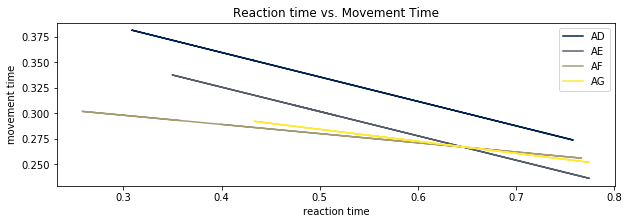

In [11]:
# Detailed reaction vs. movement
fig_rt_mt, axs_rt_mt = plt.subplots(1, figsize = (10,3))

color = plt.cm.cividis(np.linspace(0,1,len(subjects)))

for sub, c in zip(subjects,color):
    X = go_df[go_df.subject == sub].rea_time.values
    y = go_df[go_df.subject == sub].mov_time.values
    #axs_rt_mt.scatter(X, y, label = sub)
    mt_rt_reg = LinearRegression().fit(X.reshape(-1,1),y)
    axs_rt_mt.plot(X, mt_rt_reg.coef_*X+mt_rt_reg.intercept_, label = sub, color =c)

axs_rt_mt.legend()
axs_rt_mt.set_title('Reaction time vs. Movement Time')
axs_rt_mt.set_xlabel('reaction time')
axs_rt_mt.set_ylabel('movement time')

#plt.savefig(path_figs + 'individual_mt_rt.png')

Even on a trial-by-trial level, ther reaction time and the movement time are correlated

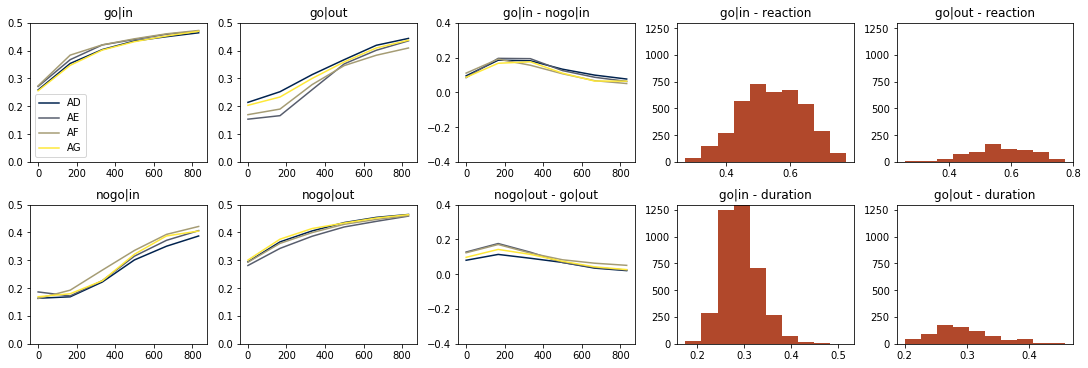

In [12]:
# How does the information presented look like in each trial category

# initialize plots
fig3 = plt.figure(constrained_layout = True, figsize = (15,5))
gs3 = fig3.add_gridspec(2, 5)

f3_axs1 = fig3.add_subplot(gs3[0:1, 0:1])
f3_axs2 = fig3.add_subplot(gs3[0:1, 1:2])
f3_axs3 = fig3.add_subplot(gs3[1:2, 0:1])
f3_axs4 = fig3.add_subplot(gs3[1:2, 1:2])

f3_axs2_1 = fig3.add_subplot(gs3[0:1, 2:3])
f3_axs4_2 = fig3.add_subplot(gs3[1:2, 2:3])

f3_axs5 = fig3.add_subplot(gs3[0:1, 3:4])
f3_axs6 = fig3.add_subplot(gs3[0:1, 4:5])
f3_axs7 = fig3.add_subplot(gs3[1:2, 3:4])
f3_axs8 = fig3.add_subplot(gs3[1:2, 4:5])

subjects = np.unique(df.subject)

# loop through all subject
for sub, c in zip(subjects,color):
    
    # define categories
    goin = df[((df.subject == sub) & (df.goResp == 1)) & (df.hitGoal == 1)]
    goout = df[((df.subject == sub) & (df.goResp == 1)) & (df.hitGoal == 0)]
    nogoin = df[((df.subject == sub) & (df.goResp == 0)) & (df.hitGoal == 1)]
    nogoout = df[((df.subject == sub) & (df.goResp == 0)) & (df.hitGoal == 0)]
    
    
    # how many targets were presented  
    # plot time against evidence
    f3_axs1.plot(np.mean(goin.loc[(df.subject ==sub),time_names]), np.mean(goin.loc[:,ev_names]),label = sub, color = c)
    f3_axs1.set_title('go|in')
    f3_axs1.set_ylim(0.0, 0.5)
    f3_axs1.legend()
    f3_axs2.plot(np.mean(goout.loc[(df.subject ==sub),time_names]), np.mean(goout.loc[:,ev_names]),label = sub, color = c)
    f3_axs2.set_title('go|out')
    f3_axs2.set_ylim(0.0, 0.5)
    
    f3_axs2_1.plot(np.mean(goin.loc[(df.subject ==sub),time_names]),np.mean(goin.loc[:,ev_names])-np.mean(nogoin.loc[:,ev_names]),label = sub, color = c)
    f3_axs2_1.set_title('go|in - nogo|in')
    f3_axs2_1.set_ylim(-0.4,0.4)
    f3_axs4_2.plot(np.mean(goin.loc[(df.subject ==sub),time_names]),np.mean(nogoout.loc[:,ev_names])-np.mean(goout.loc[:,ev_names]),label = sub, color = c)
    f3_axs4_2.set_title('nogo|out - go|out')
    f3_axs4_2.set_ylim(-0.4,0.4)
    
    f3_axs3.plot(np.mean(nogoin.loc[(df.subject ==sub),time_names]), np.mean(nogoin.loc[:,ev_names]),label = sub, color = c)
    f3_axs3.set_title('nogo|in')
    f3_axs3.set_ylim(0.0, 0.5)
    f3_axs4.plot(np.mean(nogoout.loc[(df.subject ==sub),time_names]), np.mean(nogoout.loc[:,ev_names]),label = sub, color = c)
    f3_axs4.set_title('nogo|out')
    f3_axs4.set_ylim(0.0, 0.5)

    # plot histograms of reative times and movement durations
    goin = df[(df.hitGoal == 1)]
    goout = df[(df.hitGoal == 0)]

    f3_axs5.hist(goin.loc[:,'rea_time'], alpha=0.7)
    f3_axs5.set_title('go|in - reaction')
    f3_axs5.set_ylim(0,1300)
    f3_axs6.hist(goout.loc[:,'rea_time'], alpha=0.7)
    f3_axs6.set_title('go|out - reaction')
    f3_axs6.set_ylim(0,1300)
    
    f3_axs7.hist(goin.loc[:,'mov_time'], alpha=0.7)
    f3_axs7.set_title('go|in - duration')
    f3_axs7.set_ylim(0,1300)
    f3_axs8.hist(goout.loc[:,'mov_time'], alpha=0.7)
    f3_axs8.set_title('go|out - duration')
    f3_axs8.set_ylim(0,1300)

Looking at the difference between correct and incorrect go/nogo decisions, we can see that correct trials contained more "evidence" than incorrect trials in early time windows. this effect fades out and it seems to fade out faster in out conditions.

Again, we don't see a clear difference between duration and reaction time in different conditions. However, it seems like the distribution of durations might be slightly shifted between correct and incorrect go responses, at least in the study with 10 targets.

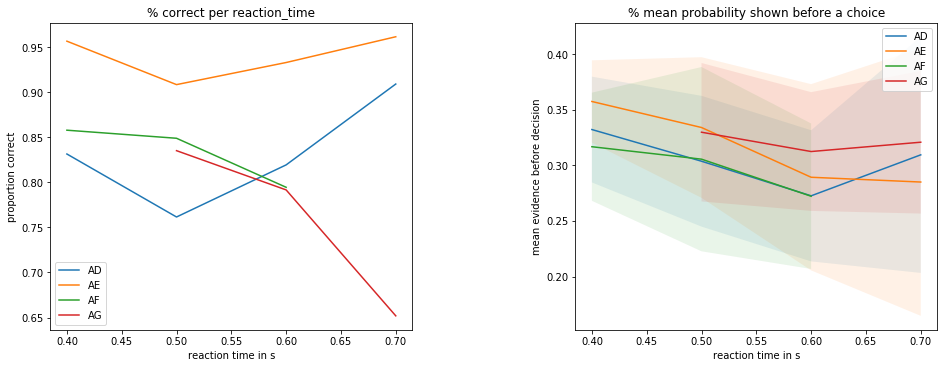

In [13]:
# is there a speed_accuracy tradeoff? 
fig4 = plt.figure(constrained_layout = True, figsize = (13,5))
gs4 = fig4.add_gridspec(1, 5)

f4_axs1 = fig4.add_subplot(gs4[0:1, 0:2])
f4_axs3 = fig4.add_subplot(gs4[0:1, 3:5])

# define reaction time bins to look at
step = 0.1
rea_bins = np.arange(0.4, 0.8,step)
subjects = np.unique(df.subject)

keys = ev_names

for sub in subjects:
    sub_cond = (df.subject == sub)
    rea_acc_df = pd.DataFrame(np.zeros((len(rea_bins),4)), index = rea_bins, columns = ['rt', 'p_correct','mean_ev', 'std_ev'])
    for bins in rea_bins:
        bin_low = (df.rea_time >= bins)
        bin_up = (df.rea_time < bins+step)
        rea_acc_df.loc[bins,'rt'] = bins
        if len(df.answer[((sub_cond & bin_low) & bin_up)])>20:
            rea_acc_df.loc[bins,'p_correct'] = np.mean(df.answer[((sub_cond & bin_low) & bin_up)]) 
            t_win = bins*6
            rea_acc_df.loc[bins,'mean_ev'] = np.mean(np.mean(df.loc[((sub_cond & bin_low) & bin_up),keys[0:int(t_win)]]))
            rea_acc_df.loc[bins,'std_ev'] = np.std(np.mean(df.loc[((sub_cond & bin_low) & bin_up),keys[0:int(t_win)]]))
        else:
            rea_acc_df.loc[bins,'p_correct'] = np.nan
            rea_acc_df.loc[bins,'mean_ev'] = np.nan
            rea_acc_df.loc[bins,'std_ev'] = np.nan
        
        
    f4_axs1.plot(rea_bins,rea_acc_df.loc[:,'p_correct'], label = sub)
    f4_axs1.set_title('% correct per reaction_time')
    f4_axs1.set_xlabel('reaction time in s')
    f4_axs1.set_ylabel('proportion correct')
    f4_axs1.legend()
    
    f4_axs3.plot(rea_bins,rea_acc_df.loc[:,'mean_ev'], label = sub)
    f4_axs3.fill_between(rea_bins, (rea_acc_df.loc[:,'mean_ev'] - rea_acc_df.loc[:,'std_ev']), (rea_acc_df.loc[:,'mean_ev'] + rea_acc_df.loc[:,'std_ev']), alpha=.1)
    f4_axs3.set_title('% mean probability shown before a choice')
    f4_axs3.set_xlabel('reaction time in s')
    f4_axs3.set_ylabel('mean evidence before decision')
    f4_axs3.legend()

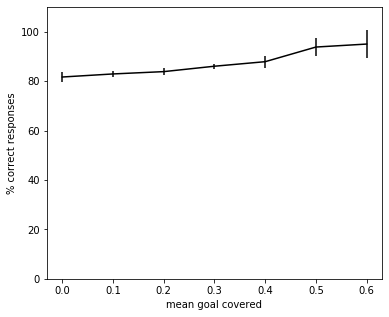

In [14]:
# what correlates best with performance? p_in, goal_covered or attacker distance to presented targets?
# we consider 1-6 time windows included

step = 0.1

p_in_bins = np.round(np.arange(0,1,step),1)
pos_bins = np.arange(0,10, 1)
goal_bins = np.round(np.arange(0,1,step),1)

rt_bins = [0.3, 0.4, 0.5, 0.6, np.nan]

rt_perf, rt_perf_ax = plt.subplots(1,1, figsize = (6,5))

p_in_colors = plt.cm.summer(np.linspace(0,1,len(rt_bins)))
pos_colors = plt.cm.autumn(np.linspace(0,1,len(rt_bins)))
goal_colors = plt.cm.winter(np.linspace(0,1,len(rt_bins)))

p_keys = p_in_names
g_keys = goal_cover_names
t_keys = p_dva_names

dva_pos = df.loc[:,t_keys].subtract(df.attackerYPos, axis = 0)

all_subs_pin = []
all_subs_pos = []
all_subs_goal = []

for sub in np.unique(df.subject):
    sub_df = df[df.subject == sub]
    
    sub_df['mean_p_in'] = np.nan
    sub_df['mean_goal'] = np.nan
    sub_df['mean_tar'] = np.nan
    
    all_rts_pin = []
    all_rts_pos = []
    all_rts_goal = []
    
    for rt in rt_bins:
        if not np.isnan(rt):
            t_win = int(rt*6)
            rt_df = sub_df[(sub_df.rea_time >= rt) & (sub_df.rea_time < rt+step)]
            rt_idx = rt_df.index
            sub_df.loc[rt_idx,'mean_p_in'] = rt_df.loc[:,p_keys[0:t_win]].mean(axis = 1)
            sub_df.loc[rt_idx,'mean_goal'] = rt_df.loc[:,g_keys[0:t_win]].mean(axis = 1)
            #print(abs(dva_pos.loc[:,t_keys[0:t_win]].mean(axis = 1))[rt_idx])
            sub_df.loc[rt_idx,'mean_tar'] = abs(dva_pos.loc[:,t_keys[0:t_win]].mean(axis = 1))[rt_idx]
        else:
            m_rt = np.mean(sub_df.rea_time)
            t_win = int(m_rt*6)
            rt_df = sub_df[sub_df.goResp == 0]
            rt_idx = rt_df.index
            sub_df.loc[rt_idx,'mean_p_in'] = rt_df.loc[:,p_keys[0:t_win]].mean(axis = 1)
            sub_df.loc[rt_idx,'mean_goal'] = rt_df.loc[:,g_keys[0:t_win]].mean(axis = 1)
            sub_df.loc[rt_idx,'mean_tar'] = abs(dva_pos.loc[:,t_keys[0:t_win]].mean(axis = 1))[rt_idx] 
                  
    all_p_in = []
    all_pos = []
    all_goal = []

    for p_in, pos, goal in zip(p_in_bins,pos_bins, goal_bins):

        p_in_df = sub_df[(sub_df.mean_p_in >= p_in) & (sub_df.mean_p_in < p_in+step)]
        p_in_perf = p_in_df.goResp.mean()
        all_p_in.append(p_in_perf)

        pos_df = sub_df[(sub_df.mean_tar >= pos) & (sub_df.mean_tar < pos+1)]
        pos_perf = pos_df.goResp.mean()
        all_pos.append(pos_perf)

        goal_df = sub_df[(sub_df.mean_goal >= goal) & (sub_df.mean_goal < goal+step)]
        goal_perf = goal_df.answer.mean()
        all_goal.append(goal_perf)

#     all_rts_pin.append(all_p_in)
#     all_rts_pos.append(all_pos)
#     all_rts_goal.append(all_goal)
        
    all_subs_pin.append(all_p_in)
    all_subs_pos.append(all_pos)
    all_subs_goal.append(all_goal)

mean_perf_pin = np.mean(all_subs_pin, axis = 0)
std_perf_pin = np.std(all_subs_pin, axis = 0)

mean_perf_pos = np.mean(all_subs_pos, axis = 0)
std_perf_pos = np.std(all_subs_pos, axis = 0)

mean_perf_goal = np.mean(all_subs_goal, axis = 0)
std_perf_goal = np.std(all_subs_goal, axis = 0)
    
#for mean, std, col, rt in zip(mean_perf_pin, std_perf_pin, p_in_colors, rt_bins):
#rt_perf_ax.errorbar(p_in_bins, (mean_perf_pin)*100, (std_perf_pin)*100, color = 'grey')
    
#for mean, std, col, rt in zip(mean_perf_pos, std_perf_pos, pos_colors, rt_bins):
#    rt_perf_ax.errorbar(pos_bins, (mean)*100, (std)*100, color = col, label = rt)
    
# for mean, std, col, rt in zip(mean_perf_goal, std_perf_goal, goal_colors, rt_bins):
rt_perf_ax.errorbar(goal_bins, (mean_perf_goal)*100, (std_perf_goal)*100, color = 'black')#, color = col, label = rt)
    
# rt_perf_ax.legend(loc='lower right')
rt_perf_ax.set_ylim(0,110)
rt_perf_ax.set_xlabel('mean goal covered')
rt_perf_ax.set_ylabel ('% correct responses');

#plt.savefig(path_figs+'performance_cover_correc.png')
#rt_perf_ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#rt_perf_ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [15]:
np.mean(all_subs_pin, axis = 0)

array([0.01332979, 0.03736745, 0.07788227, 0.1835255 , 0.32207188,
       0.60091357, 0.8166752 , 0.92425924, 0.97767852, 0.98989993])

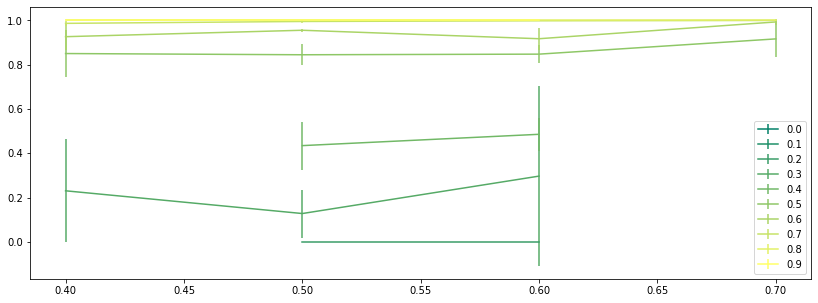

In [16]:
# further exploration of the speed accuracy trade off 
# bin the probabilities of a hit 

step = 0.1
p_in_bins = np.round(np.arange(0,1,step),1)
rt_bins = np.arange(0.3, 0.8, step)
rt_perf, rt_perf_ax = plt.subplots(1, figsize = (14,5))

colors = plt.cm.summer(np.linspace(0,1,len(p_in_bins)))

p_keys = p_in_names
g_keys = goal_cover_names
t_keys = p_dva_names

all_subs = []

for sub in np.unique(go_df.subject):
    sub_df = go_df[go_df.subject == sub]
    
    all_rts = []
    
    for rt in rt_bins:
        t_win = int(rt*6)
        rt_df = sub_df[(sub_df.rea_time >= rt) & (sub_df.rea_time < rt+step)]
        rt_df['mean_p_in'] = rt_df.loc[:,p_keys[0:t_win]].mean(axis = 1)
        rt_df['mean_goal'] = rt_df.loc[:,g_keys[0:t_win]].mean(axis = 1)
        rt_df['mean_tar'] = rt_df.loc[:,t_keys[0:t_win]].mean(axis = 1)

        all_p_in = []
        
        for p_in in p_in_bins:
            
            p_in_df = rt_df[(rt_df.mean_p_in >= p_in) & (rt_df.mean_p_in < p_in+step)]
            perf = p_in_df.answer.mean()
            all_p_in.append(perf)
        all_rts.append(all_p_in)
    all_subs.append(all_rts)

mean_perf = np.mean(all_subs, axis = 0).T
std_perf = np.std(all_subs, axis = 0).T
    
for mean, std, col, p_in in zip(mean_perf, std_perf, colors, p_in_bins):
    
    rt_perf_ax.errorbar(rt_bins, mean, std, color = col, label = p_in)
    
rt_perf_ax.legend()

It is not quite clear, if there is a speed accuracy trade off. For some participants, longer reaction times are associated with worse performance, in others, the reaction time goes up again for even longer reaction times. 

Most likely, both reaction time and performance depend on the evidence presented before the movement. This is confirmed. The more evidence was shown, the shorter was the reaction time.

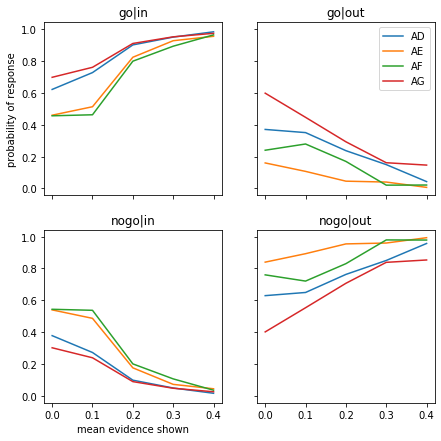

In [17]:
# Does the mean evidence shown during a trial influence the decision?
# compute the "reaction time" a no-go as the upper quartile of manual reaction times
# init the figure
fig5, axs5 = plt.subplots(2,2, figsize = (7,7), sharex = True, sharey = True)

# summary of the data by subject
by_sub = df.groupby('subject')
sub_sum = by_sub.describe()

no_rea_time = sub_sum.rea_time['75%']
subjects = np.unique(df.subject)

# fill in df
for sub in subjects:
    df.loc[(df.goResp == 0)&(df.subject == sub),'rea_time'] = no_rea_time[sub] 
  

p_keys = ev_names

# compute the mean information presented before the "decision"
d_tw = np.round(df.rea_time*6)-1

mean_seen = []
for line in df.index:
    mean_seen.append(np.mean(df.loc[line, p_keys[0:int(d_tw[line])]]))
df['mean_seen'] = mean_seen    
# compute pgo|in, pgo|out, pnogo|in, pnogo|out of each mean information bin
step = 0.1
info_bin = np.arange(0, 0.5, step)

for sub in np.unique(df.subject):
    sub_cond = (df.subject == sub)
    ev_acc_df = pd.DataFrame(np.zeros((len(info_bin),5)), index = info_bin, columns = ['evidence', 'go|in','go|out','nogo|in','nogo|out'])

    for bins in info_bin:
        bin_low = (df.mean_seen >= bins)
        bin_up = (df.mean_seen < bins+step)
        ev_acc_df.loc[bins, 'evidence'] = bins
        ev_acc_df.loc[bins, 'go|in'] = given(df[((sub_cond & bin_low)&bin_up)].goResp, df[((sub_cond & bin_low)&bin_up)].hitGoal, 1, 1)
        ev_acc_df.loc[bins, 'go|out'] = given(df[((sub_cond & bin_low)&bin_up)].goResp, df[((sub_cond & bin_low)&bin_up)].hitGoal, 1, 0)
        ev_acc_df.loc[bins, 'nogo|in'] = given(df[((sub_cond & bin_low)&bin_up)].goResp, df[((sub_cond & bin_low)&bin_up)].hitGoal, 0, 1)
        ev_acc_df.loc[bins, 'nogo|out'] = given(df[((sub_cond & bin_low)&bin_up)].goResp, df[((sub_cond & bin_low)&bin_up)].hitGoal, 0, 0)

    axs5[0,0].plot(ev_acc_df.evidence,ev_acc_df['go|in'], label = sub)
    axs5[0,0].set_title('go|in')
    axs5[0,0].set_ylabel('probability of response')
    axs5[0,1].plot(ev_acc_df.evidence,ev_acc_df['go|out'], label = sub)
    axs5[0,1].set_title('go|out')
    axs5[0,1].legend()
    axs5[1,0].plot(ev_acc_df.evidence,ev_acc_df['nogo|in'], label = sub)
    axs5[1,0].set_title('nogo|in')
    axs5[1,0].set_xlabel('mean evidence shown')
    axs5[1,1].plot(ev_acc_df.evidence,ev_acc_df['nogo|out'], label = sub)
    axs5[1,1].set_title('nogo|out')


Yes, the more evidence was shown over the experiment, the more often a correct response was given. This figure is not ideal for interpretation

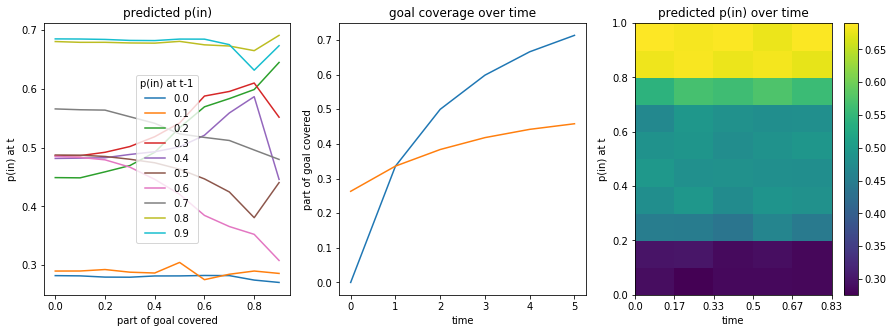

In [18]:
# Baseline description: how do the changes in information behave with more information shown/more width of the goal covered?
# the things we want to loop through
step = 0.1
# probability of an "in" trial
p_bins = np.round(np.arange(0,1,step),1)
# range of the goal covered
cov_steps = np.round(np.arange(0,1,step),1)
# columns to look at 
cols = p_in_names
# goal cover columns
gc_cols = goal_cover_names

# init an array to save the mean column values
time_df = []

# init a figure
fig_bl, axs_bl = plt.subplots(1,3, figsize = (15,5))

# start the loop.
# First, we filter our data according to the probability bins

for pb in p_bins:
    
    # init empty arrays for the mean value over columns
    col_means = []
    time_col_means = []
    # loop over columns
    
    for col_n, col in enumerate(cols[:-1]):
        # get the probability bins in the specific column
        binned_vals = df[(df[col]>=pb) & (df[col]<pb+step)]
        # get the expected probability in the next bin
        new_p_in = binned_vals[cols[col_n+1]]
        
        #### For p(hit|t-1 & time)#####
        # collect in the data frame for mean time
        time_col_means.append(np.nanmean(new_p_in, axis = 0))
        ################################
        
        #### For p(hit|t-1 & goal) #####
        # get the goal coverage for these columns
        cov  = binned_vals[gc_cols[col_n]]
        # bind and combine to one df 
        new_pi_cov = pd.concat([new_p_in, cov], axis = 1)
        try:
            all_cols = pd.concat([all_cols,new_p_in],axis = 0)
        except:
            all_cols = new_p_in
        
        # prepare that df to work with it in the next loop
        new_pi_cov.reset_index(inplace = True)
        new_pi_cov.columns = ['index', 'p_in', 'goal']
        
        means = []
        
        # go through all goal_coverage steps defined
        for cov in cov_steps:
            # get mean value at that time
            p_in_mean = np.mean(new_pi_cov[(new_pi_cov.goal>=cov) & (new_pi_cov.goal>cov)].p_in)
            means.append(p_in_mean)
        col_means.append(means)
        
        ############p(hit|t-1 & time)###################
        time_df.append(time_col_means)
        
    # plot everything
    axs_bl[0].plot(cov_steps, np.nanmean(col_means, axis = 0), label = pb)
axs_bl[0].legend(title = 'p(in) at t-1')
axs_bl[0].set_title('predicted p(in)')
axs_bl[0].set_xlabel('part of goal covered')
axs_bl[0].set_ylabel('p(in) at t')

# on the second plot: how does the goal coverage vary over time?

axs_bl[1].plot(np.arange(0,6),np.mean(df.loc[:,goal_cover_names],  axis = 0), label = 'goal')
axs_bl[1].plot(np.arange(0,6),np.mean(df.loc[:,ev_names],  axis = 0), label = 'ev')
axs_bl[1].set_title('goal coverage over time')
axs_bl[1].set_xlabel('time')
axs_bl[1].set_ylabel('part of goal covered')

# on the third plot: colormap how p(hit|t-1) changes over time

p_bl = axs_bl[2].pcolormesh(time_df)
axs_bl[2].set_title('predicted p(in) over time')
axs_bl[2].set_xlabel('time')
axs_bl[2].set_ylabel('p(in) at t')
axs_bl[2].set_xticklabels(np.round(np.linspace(0,1,7),2))
axs_bl[2].set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
fig_bl.colorbar(p_bl, ax = axs_bl[2])


# the time_df is our baseline. However, we might want to compute that for each participant.
# therefore, we define a function that allows us to do that

def get_baseline(dat, pin_bins, col_names, append_first = None, plot = False, reverse = False):
    
    # init an array to save the mean column values    
    time_df = []
    names = col_names.copy()
    
    if reverse:
        
        names.reverse()

    # get the update step from pin_bins
    step = np.unique(np.diff(pin_bins))[0]
    
    # define the column names. for the baseline, this is 
    
    if plot:
    # init a figure
        fig, axs = plt.subplots(1, figsize = (5,5))

    # start the loop.
    # First, we filter our data according to the probability bins
    
    for pb in pin_bins:
    
        # init array
        if append_first is None:
            time_col_means = []
        else:
            time_col_means = [append_first]
    
        # loop over columns
        for col_n, col in enumerate(names[:-1]):
            
            # get the probability bins in the specific column
            binned_vals = dat[(dat[col]>=pb) & (dat[col]<pb+step)]
            # get the expected probability in the next bin

            new_p_in = binned_vals[names[col_n+1]]
        
            # collect in the data frame for mean time
            time_col_means.append(np.nanmean(new_p_in, axis = 0))
        time_df.append(time_col_means)
        
    out_df = np.array(time_df)
    out_df = pd.DataFrame(out_df, columns = names[1:], index = pin_bins)
    
    if plot:
        p = axs.pcolormesh(out_df, vmin = 0 , vmax= 1)
        axs.set_title('predicted p(in) over time')
        axs.set_xlabel('time')
        axs.set_ylabel('p(in) at t')
        axs.set_xticklabels(np.round(np.linspace(0,1,7),2))
        axs.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]);
        #fig.colorbar(p, ax = axs);
    
    return out_df
#plt.savefig(path_figs + 'p_in_time_cbar.png')       

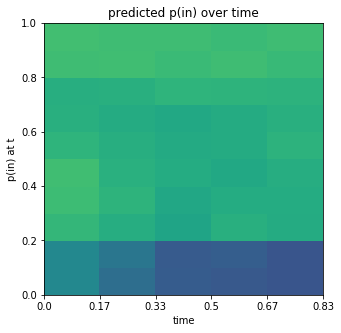

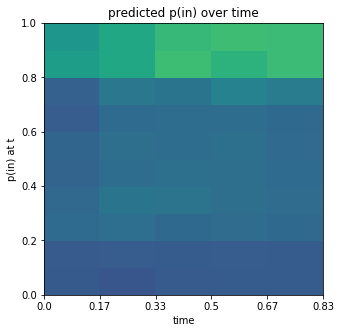

In [19]:
# baseline in "in" and "out" trials
p_bins = np.round(np.arange(0,1,step),1)
keys = p_in_names
base_in = get_baseline(df[df.goResp == 1], p_bins, keys, append_first = None, plot = True, reverse = False)
#plt.savefig(path_figs + 'p_in_go.png')
base_out = get_baseline(df[df.goResp == 0], p_bins, keys, append_first = None, plot = True, reverse = False)
#plt.savefig(path_figs + 'p_in_nogo.png')

The probability of an "in" trial develops non-uniformly and depend on the information presented earlier in the experiment. Specifically, the more of the goal is covered, the more likely the next update is to bring p(in) closer to the true value. Since already after 2 or 3 frames shown, more than 60% of the goal is covered, this influences the baseline of presented targets.

On the right, we see which p(in) occured on average at time t+1, after at time t a given information was presented. We see that p(in)> 0.5 tend to drift towards 1 and p(in) < 0.5 tend to drift towards 0.

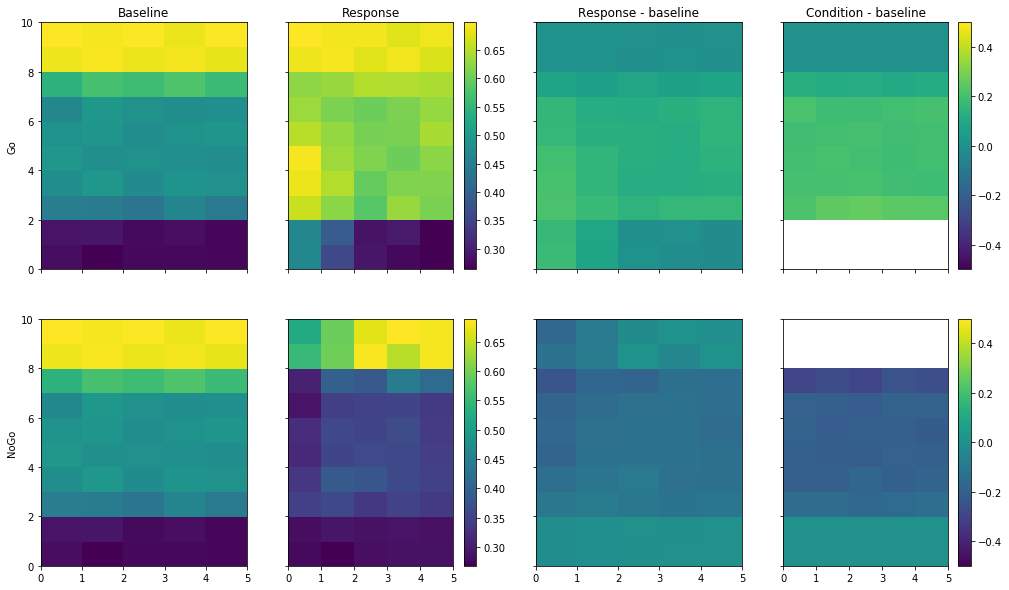

In [20]:
# compute the difference between this baseline, go-trials and no-go trials

fig_bl, axs_bl = plt.subplots(2,4, figsize = (17, 10), sharex= True, sharey = True)

p_bins = np.round(np.arange(0,1,step),1)
keys = p_in_names

time = np.round(np.arange(0,1-(1/6),(1/6)),2)

baseline = get_baseline(df, p_bins, keys)
go = get_baseline(df[df.goResp == 1], p_bins, keys)
nogo = get_baseline(df[df.goResp == 0], p_bins, keys)
diff_go = go - baseline
diff_nogo = nogo - baseline

in_df = get_baseline(df[df.hitGoal == 1], p_bins, keys)
diff_in = in_df - baseline
out_df = get_baseline(df[df.hitGoal == 0], p_bins, keys)
diff_out = out_df - baseline


p_b = axs_bl[0,0].pcolormesh(baseline)
axs_bl[0,0].set_title('Baseline')
axs_bl[0,0].set_ylabel('Go')

p_g = axs_bl[0,1].pcolormesh(go)
axs_bl[0,1].set_title('Response')
fig_bl.colorbar(p_g, ax = axs_bl[0,1])

p_gb = axs_bl[0,2].pcolormesh(diff_go, vmin = -0.5 , vmax= 0.5)
axs_bl[0,2].set_title('Response - baseline')

p_ib = axs_bl[0,3].pcolormesh(diff_in, vmin = -0.5 , vmax= 0.5)
axs_bl[0,3].set_title('Condition - baseline')
fig_bl.colorbar(p_ib, ax = axs_bl[0,3])


p_b = axs_bl[1,0].pcolormesh(baseline)
axs_bl[1,0].set_ylabel('NoGo')

p_ng = axs_bl[1,1].pcolormesh(nogo)
fig_bl.colorbar(p_ng, ax = axs_bl[1,1])

p_ngb = axs_bl[1,2].pcolormesh(diff_nogo, vmin = -0.5 , vmax= 0.5)

p_ob = axs_bl[1,3].pcolormesh(diff_out, vmin = -0.5 , vmax= 0.5)
fig_bl.colorbar(p_ob, ax = axs_bl[1,3]);

"Go" trials are characterized by stronger updates towards p(in) = 1 in the first tw, especially from p_in windows below 0.5.

"NoGo" trials are characterized by stronger updates towards p(in) = 0 (negative values) in the first tw, especially from p_in windows above 0.5.

This is partially explained by the difference between "in" and "out" trials

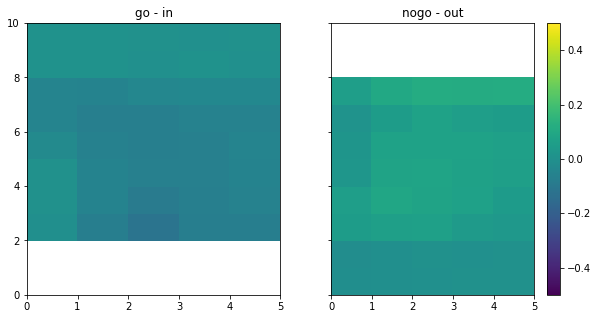

In [21]:
# plot the difference between responses and true in/out trials

fig_dd, axs_dd = plt.subplots(1,2, figsize = (10,5), sharex = True, sharey=True)
    
go_in = diff_go - diff_in
nogo_out = diff_nogo - diff_out


axs_dd[0].pcolormesh(go_in, vmin = -0.5 , vmax= 0.5)
axs_dd[0].set_title('go - in')

cm = axs_dd[1].pcolormesh(nogo_out, vmin = -0.5 , vmax= 0.5)
axs_dd[1].set_title('nogo - out')

fig_dd.colorbar(cm, ax = axs_dd[1]);

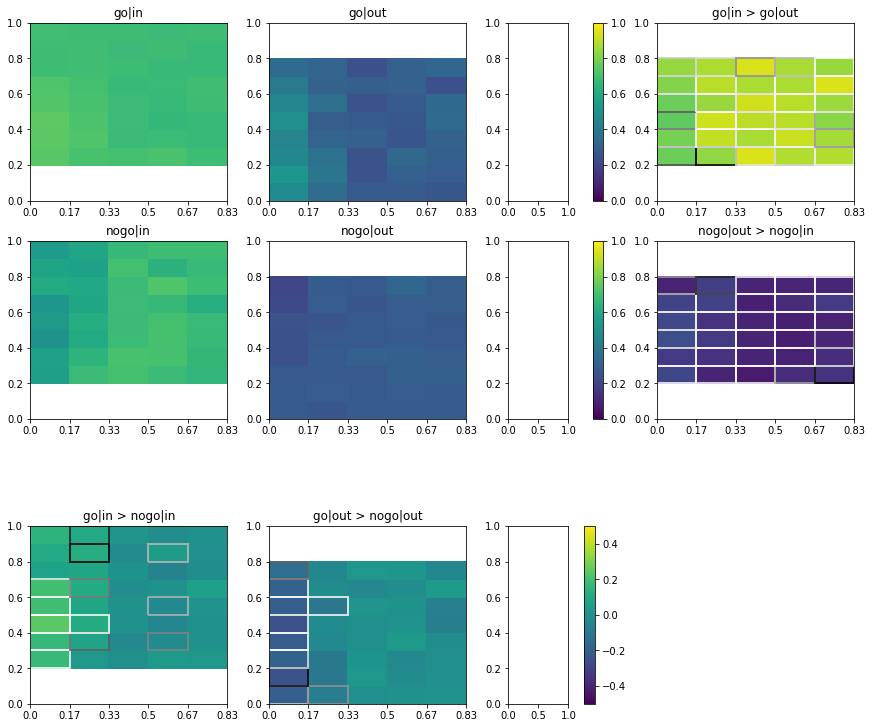

In [22]:
# compare correct and incorrect trials

fig_resp_comp =  plt.figure(constrained_layout = True, figsize = (12,10))
gs = fig_resp_comp.add_gridspec(10, 10)

fig_rc_ax1 = fig_resp_comp.add_subplot(gs[:3, :3])
fig_rc_ax2 = fig_resp_comp.add_subplot(gs[:3, 3:6])
fig_rc_ax3 = fig_resp_comp.add_subplot(gs[:3, 7:])
fig_rc_ax4 = fig_resp_comp.add_subplot(gs[3:6, :3])
fig_rc_ax5 = fig_resp_comp.add_subplot(gs[3:6, 3:6])
fig_rc_ax6 = fig_resp_comp.add_subplot(gs[3:6, 7:])
fig_rc_ax7 = fig_resp_comp.add_subplot(gs[7:, :3])
fig_rc_ax8 = fig_resp_comp.add_subplot(gs[7:, 3:6])

fig_colbar1 = fig_resp_comp.add_subplot(gs[:3, 6:7])
fig_colbar2 = fig_resp_comp.add_subplot(gs[3:6, 6:7])
fig_colbar3 = fig_resp_comp.add_subplot(gs[7:, 6:7])


p_bins = np.round(np.arange(0,1,step),1)
keys = p_in_names

time = np.round(np.arange(0,1-(1/6),(1/6)),2)

go_in_subs = []
go_out_subs = []
nogo_in_subs = []
nogo_out_subs = []

for sub in np.unique(df.subject):
    
    df_6 = df[df.subject == sub]
    
    # go|in
    go_in_subs.append(get_baseline(df_6[(df_6.goResp == 1) & (df_6.hitGoal == 1)], p_bins, keys))

    # go|out
    go_out_subs.append(get_baseline(df_6[(df_6.goResp == 1) & (df_6.hitGoal == 0)], p_bins, keys))

    # nogo|in
    nogo_in_subs.append(get_baseline(df_6[(df_6.goResp == 0) & (df_6.hitGoal == 1)], p_bins, keys))

    # nogo|out
    nogo_out_subs.append(get_baseline(df_6[(df_6.goResp == 0) & (df_6.hitGoal == 0)], p_bins, keys))

all_gi = pd.concat(go_in_subs)
go_in = all_gi.groupby(all_gi.index).mean()

all_go = pd.concat(go_out_subs)
go_out = all_go.groupby(all_go.index).mean()

all_ni = pd.concat(nogo_in_subs)
nogo_in = all_ni.groupby(all_ni.index).mean()

all_no = pd.concat(nogo_out_subs)
nogo_out = all_no.groupby(all_ni.index).mean()

    
# go|in - go|out
resp_go = go_in - go_out

sig_go =  pd.DataFrame(np.zeros(resp_go.shape), columns = resp_go.columns, index = resp_go.index)

# go|in - nogo|in
goal_in = go_in - nogo_in

sig_in = pd.DataFrame(np.zeros(goal_in.shape), columns = goal_in.columns, index = goal_in.index)

# nogo|out - nogo|in
resp_nogo = nogo_out - nogo_in

sig_nogo =  pd.DataFrame(np.zeros(resp_nogo.shape), columns = resp_nogo.columns, index = resp_nogo.index)

# nogo|out - go|out
goal_out = nogo_out - go_out

sig_out = pd.DataFrame(np.zeros(goal_out.shape), columns = goal_out.columns, index = goal_out.index)

for col in sig_in.columns:
    for index in sig_in.index:
        
        T_in, p_in = stats.ttest_rel(all_gi.loc[index][col].values, all_ni.loc[index][col].values)
        T_out, p_out = stats.ttest_rel(all_go.loc[index][col].values, all_no.loc[index][col].values)
        T_go, p_go = stats.ttest_rel(all_gi.loc[index][col].values, all_go.loc[index][col].values)
        T_nogo, p_nogo = stats.ttest_rel(all_no.loc[index][col].values, all_ni.loc[index][col].values)
    
        sig_in.loc[index][col] = p_in
        sig_out.loc[index][col] = p_out
        sig_go.loc[index][col] = p_go
        sig_nogo.loc[index][col] = p_nogo

p_sc = fig_rc_ax1.pcolormesh(go_in, vmin = 0 , vmax= 1)
fig_rc_ax1.set_title('go|in')
fig_rc_ax1.set_xticklabels(np.round(np.linspace(0,1,7),2))
fig_rc_ax1.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
fig_rc_ax2.pcolormesh(go_out, vmin = 0 , vmax= 1)
fig_rc_ax2.set_title('go|out')
fig_rc_ax2.set_xticklabels(np.round(np.linspace(0,1,7),2))
fig_rc_ax2.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
fig_rc_ax3.pcolormesh(resp_go, vmin = -0.5 , vmax= 0.5)
fig_rc_ax3.set_title('go|in > go|out')
fig_rc_ax3.set_xticklabels(np.round(np.linspace(0,1,7),2))
fig_rc_ax3.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

p_go = np.ma.masked_array(sig_go, sig_go > 0.05)
fig_rc_ax3.pcolormesh(p_go, alpha=0.8, zorder=2, facecolor='none', edgecolors='black', cmap = 'Greys')

fig_resp_comp.colorbar(p_sc,ax = fig_colbar1)

fig_rc_ax4.pcolormesh(nogo_in, vmin = 0 , vmax= 1)
fig_rc_ax4.set_title('nogo|in')
fig_rc_ax4.set_xticklabels(np.round(np.linspace(0,1,7),2))
fig_rc_ax4.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
fig_rc_ax5.pcolormesh(nogo_out, vmin = 0 , vmax= 1)
fig_rc_ax5.set_title('nogo|out')
fig_rc_ax5.set_xticklabels(np.round(np.linspace(0,1,7),2))
fig_rc_ax5.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
fig_rc_ax6.pcolormesh(resp_nogo, vmin = -0.5 , vmax= 0.5)
fig_rc_ax6.set_xticklabels(np.round(np.linspace(0,1,7),2))
fig_rc_ax6.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
fig_rc_ax6.set_title('nogo|out > nogo|in')
fig_resp_comp.colorbar(p_sc,ax = fig_colbar2)

p_nogo = np.ma.masked_array(sig_nogo, sig_nogo > 0.05)
fig_rc_ax6.pcolormesh(p_nogo, alpha=0.8, zorder=2, facecolor='none', edgecolors='black', cmap = 'Greys')


p_sc_2 = fig_rc_ax7.pcolormesh(goal_in, vmin = -0.5 , vmax= 0.5)
fig_rc_ax7.set_title('go|in > nogo|in')
fig_rc_ax7.set_xticklabels(np.round(np.linspace(0,1,7),2))
fig_rc_ax7.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

p_in = np.ma.masked_array(sig_in, sig_in > 0.05)
fig_rc_ax7.pcolormesh(p_in, alpha=0.8, zorder=2, facecolor='none', edgecolors= 'black',cmap = 'Greys')

fig_rc_ax8.pcolormesh(goal_out, vmin = -0.5 , vmax= 0.5)
fig_rc_ax8.set_title('go|out > nogo|out')
fig_rc_ax8.set_xticklabels(np.round(np.linspace(0,1,7),2))
fig_rc_ax8.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

p_out = np.ma.masked_array(sig_out, sig_out > 0.05)
fig_rc_ax8.pcolormesh(p_out, alpha=0.8, zorder=2, facecolor='none', edgecolors='black', cmap = 'Greys')

fig_resp_comp.colorbar(p_sc_2,ax = fig_colbar3)

#plt.savefig(path_figs + 'differences.png')


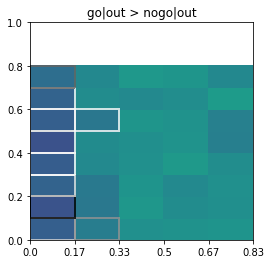

In [23]:
fig, ax = plt.subplots(1,1, figsize = (4,4))
ax.pcolormesh(goal_out, vmin = -0.5 , vmax= 0.5)
ax.set_title('go|out > nogo|out')
ax.set_xticklabels(np.round(np.linspace(0,1,7),2))
ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.pcolormesh(p_out, alpha=0.8, zorder=2, facecolor='none', edgecolors='black', cmap = 'Greys')

#plt.savefig(path_figs + 'goout_nogoout_mesh.png');

KeyError: 'rev_pi_sing6'

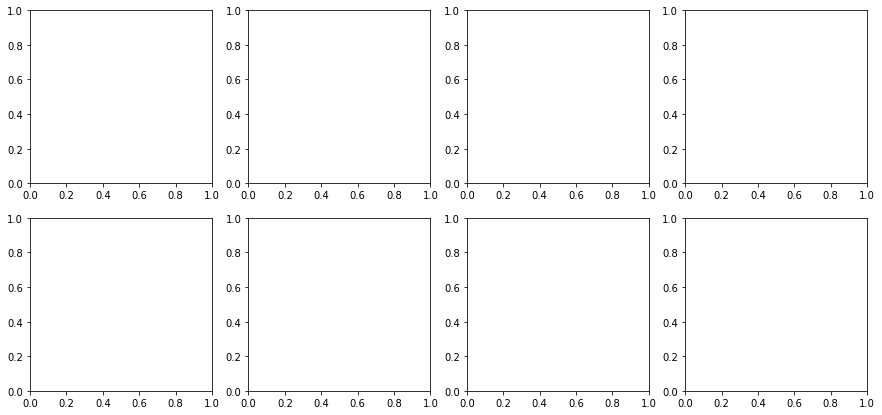

In [24]:
# compute the differences to the baseline in go trials, reverse correlated to hand movement onset

fig_revbl, axs_revbl = plt.subplots(2,4, figsize = (15, 7))

p_bins = np.round(np.arange(0,1,step),1)
rev_keys = rev_p_in_names

rev_baseline_subs = []
rev_go_in_subs = []
rev_go_out_subs = []

for sub in np.unique(df.subject):
    
    sub_df = df[df.subject == sub]
    rev_baseline_subs.append(get_baseline(sub_df, p_bins, rev_keys, reverse = True))
    rev_go_in_subs.append(get_baseline(sub_df[sub_df.hitGoal == 1], p_bins, rev_keys, reverse = True))
    rev_go_out_subs.append(get_baseline(sub_df[sub_df.hitGoal == 0], p_bins, rev_keys, reverse = True))

rev_all_baseline = pd.concat(rev_baseline_subs)
rev_baseline = rev_all_baseline.groupby(rev_all_baseline.index).mean() 
    
rev_gi = pd.concat(rev_go_in_subs)
rev_go_in = rev_gi.groupby(rev_gi.index).mean()

rev_go = pd.concat(rev_go_out_subs)
rev_go_out = rev_go.groupby(rev_go.index).mean()

rev_diff_out = rev_go_out - rev_baseline
sig_diff_out = pd.DataFrame(np.zeros(rev_diff_out.shape), columns = rev_diff_out.columns, index = rev_diff_out.index)


rev_diff_in = rev_go_in - rev_baseline
sig_diff_in = pd.DataFrame(np.zeros(rev_diff_in.shape), columns = rev_diff_in.columns, index = rev_diff_in.index)


rev_go_resp = rev_go_in - rev_go_out
sig_rev_go =  pd.DataFrame(np.zeros(rev_go_resp.shape), columns = rev_go_resp.columns, index = rev_go_resp.index)


for col in rev_diff_in.columns:
    for index in rev_diff_in.index:
        
        T_go, p_go = stats.ttest_rel(rev_gi.loc[index][col].values, rev_go.loc[index][col].values)
        T_diff_out, p_diff_out = stats.ttest_rel(rev_go.loc[index][col].values, rev_all_baseline.loc[index][col].values)
        T_diff_in, p_diff_in = stats.ttest_rel(rev_gi.loc[index][col].values, rev_all_baseline.loc[index][col].values)
        
        
        sig_rev_go.loc[index][col] = p_go
        sig_diff_out.loc[index][col] = p_diff_out
        sig_diff_in.loc[index][col] = p_diff_in

sig_go_masked = np.ma.masked_array(sig_rev_go, sig_rev_go > 0.05)
sig_out_masked = np.ma.masked_array(sig_diff_out, sig_diff_out > 0.05)
sig_in_masked = np.ma.masked_array(sig_diff_in, sig_diff_in > 0.05)
        
        
p_b6 = axs_revbl[0,0].pcolormesh(rev_baseline, vmin = 0 , vmax= 1)
axs_revbl[0,0].set_title('Reversed Baseline')
axs_revbl[0,0].set_ylabel('In')

p_gi6 = axs_revbl[0,1].pcolormesh(rev_go_in, vmin = 0 , vmax= 1)
axs_revbl[0,1].set_title('Reversed Condition')
fig_revbl.colorbar(p_gi6, ax = axs_revbl[0,1])

p_gib6 = axs_revbl[0,2].pcolormesh(rev_diff_in, vmin = -0.5 , vmax= 0.5)
axs_revbl[0,2].set_title('Condition - Baseline')
fig_revbl.colorbar(p_gib6, ax = axs_revbl[0,2])
axs_revbl[0,2].pcolormesh(sig_in_masked, alpha=0.8, zorder=2, facecolor='none', edgecolors='black', cmap = 'Greys');

p_b6 = axs_revbl[1,0].pcolormesh(rev_baseline, vmin = 0 , vmax= 1)
axs_revbl[1,0].set_ylabel('Out')

p_go6 = axs_revbl[1,1].pcolormesh(rev_go_out, vmin = 0 , vmax= 1)
fig_revbl.colorbar(p_go6, ax = axs_revbl[1,1])

p_gob6 = axs_revbl[1,2].pcolormesh(rev_diff_out, vmin = -0.5 , vmax= 0.5)
fig_revbl.colorbar(p_gob6, ax = axs_revbl[1,2])
axs_revbl[1,2].pcolormesh(sig_out_masked, alpha=0.8, zorder=2, facecolor='none', edgecolors='black', cmap = 'Greys');


p_gr6 = axs_revbl[1,3].pcolormesh(rev_go_resp, vmin = -0.5, vmax = 0.5)
axs_revbl[1,3].pcolormesh(sig_go_masked, alpha=0.8, zorder=2, facecolor='none', edgecolors='black', cmap = 'Greys');


In [ ]:
# Specifically: Check "changes of mind"
# Define: A "change of mind" could occur if the information presented favoured different responses.
# in the columns "p_hitGoal" and "rev_p_hitGoal" we encoded the deviation from the current information to the true target.
# we can now look, which update happened between timewindows and how the performance in the task changed depending on these updates.

# here, we look into all trials

tws = np.arange(6)
keys =  p_in_names
min_p = df.pi_pos01.describe()['min']
max_p = df.pi_pos01.describe()['max']
step = 0.1
cmp = plt.get_cmap('PuOr_r')
# compute the update betweeen hitGoal times

hg_bins = np.arange(min_p, max_p, step)

fig_com, axs_com = plt.subplots(2,3, figsize = (12,7), sharex = True, sharey = True)
fig_mean, axs_mean = plt.subplots(2,5, figsize = (15,7), sharex = True, sharey = True)
plt.tight_layout

idx = 0


for tw in tws:
    from_to = pd.DataFrame(np.zeros((len(hg_bins),len(hg_bins))),columns = hg_bins, index = hg_bins)
    mean_quad = pd.DataFrame(np.zeros((2,2)), columns = ['to_out', 'to_in'], index = ['from_out', 'from_in'])
    key = keys[tw]#int(math.floor(tw * nTar))]

    for row, from_bin in enumerate(hg_bins):
        from_low = (df[key] >= from_bin)
        from_up = (df[key] < from_bin+step)
        if from_bin == max(hg_bins):
            from_up = (df[key] < 1)

        from_df = df[from_low&from_up]

        try:
            to_col = keys[tw+1] #int(math.floor(tw * nTar))

            for col, to_bin in enumerate(hg_bins):
                to_low = (from_df[to_col] >= to_bin)
                to_up = (from_df[to_col] < to_bin+step)
                if to_bin == max(hg_bins):
                    to_up = (from_df[to_col] < 1)

                from_to_df = from_df[to_low&to_up]

                if len(from_to_df.goResp)>10:
                    from_to.loc[from_bin,to_bin] = np.mean(from_to_df.goResp)
                else:
                    from_to.loc[from_bin,to_bin] = np.nan
        except:
            pass

    mean_quad.loc['from_out']['to_out'] = from_to.loc[0.0:0.4, 0.0:0.4].mean().mean()
    mean_quad.loc['from_in']['to_out'] = from_to.loc[0.5:, 0.0:0.4].mean().mean()
    mean_quad.loc['from_in']['to_in'] = from_to.loc[0.5:, 0.5:].mean().mean()
    mean_quad.loc['from_out']['to_in'] = from_to.loc[0.0:0.4,0.5:].mean().mean()

    if idx <= 7:
        p = axs_com.flatten()[idx].pcolormesh(from_to, vmax = 1, vmin = 0, cmap = cmp)
        axs_com.flatten()[idx].set_xticklabels(np.round(np.arange(0,1,0.2),1))
        axs_com.flatten()[idx].set_yticklabels(np.round(np.arange(0,1,0.2),1))

        #if idx == 16:
            #axs_com.flatten()[idx].set_xlabel('p(in), t+1')
        #if idx == 5:
            #axs_com.flatten()[idx].set_ylabel('p(in), t')
        #if (np.array([4,9,14,19]) == idx).any():
            #fig_com.colorbar(p, ax = axs_com.flatten()[idx]);

        #axs_com.flatten()[idx].set_title('target {}')        

    p_m = axs_mean.flatten()[idx].pcolormesh(mean_quad, vmax = 1, vmin = 0, cmap = cmp)
    if idx == 16:
        axs_mean.flatten()[idx].set_xlabel('p(in), t+1')
    if idx == 5:
        axs_mean.flatten()[idx].set_ylabel('p(in), t')
    #if (np.array([4,9,14,19]) == idx).any():
        #fig_mean.colorbar(p_m, ax = axs_mean.flatten()[idx]);
    axs_mean.flatten()[idx].set_title(key)        
    idx +=1



#fig_com.savefig(path_figs + 'p_in_resolved_go_nogo.png')

In [ ]:
# Specifically: Check "changes of mind"
# This is simulated data for our drift diffusion models
# Define: A "change of mind" could occur if the information presented favoured different responses.
# in the columns "p_hitGoal" and "rev_p_hitGoal" we encoded the deviation from the current information to the true target.
# we can now look, which update happened between timewindows and how the performance in the task changed depending on these updates.

# here, we look into all trials

d_m1 = pd.read_csv('dat_rsp_m1_noise0.csv').reset_index(drop=True)
d_m1.loc[d_m1.loc[:,'0']=='nogo','0'] = 0
d_m1.loc[d_m1.loc[:,'0']=='go','0'] = 1

d_m1.loc[d_m1.loc[:,'0']=='go','0'] = d_m1.loc[d_m1.loc[:,'0']=='go','0'].astype('int32')

tws = np.arange(9)
keys =  ['pi_pos01', 'pi_pos02', 'pi_pos03', 'pi_pos04', 'pi_pos05', 'pi_pos06', 'pi_pos07', 'pi_pos08', 'pi_pos09', 'pi_pos10']
min_p = d_m1.pi_pos01.describe()['min']
max_p = d_m1.pi_pos02.describe()['max']
step = 0.11
cmp = plt.get_cmap('PuOr_r')
# compute the update betweeen hitGoal times

hg_bins = np.arange(min_p, max_p, step)

fig_com, axs_com = plt.subplots(2,4, figsize = (13,7), sharex = True, sharey = True)
fig_mean, axs_mean = plt.subplots(2,5, figsize = (15,7), sharex = True, sharey = True)
plt.tight_layout

idx = 0

tar_df = d_m1
for tw in tws:
    from_to = pd.DataFrame(np.zeros((len(hg_bins),len(hg_bins))),columns = hg_bins, index = hg_bins)
    mean_quad = pd.DataFrame(np.zeros((2,2)), columns = ['to_out', 'to_in'], index = ['from_out', 'from_in'])
    key = keys[tw]

    for row, from_bin in enumerate(hg_bins):
        from_low = (tar_df[key] >= from_bin)
        from_up = (tar_df[key] < from_bin+step)
        if from_bin == max(hg_bins):
            from_up = (tar_df[key] < 1)

        from_df = tar_df[from_low&from_up]
        to_col = keys[tw+1]

        for col, to_bin in enumerate(hg_bins):
            to_low = (from_df[to_col] >= to_bin)
            to_up = (from_df[to_col] < to_bin+step)

            if to_bin == max(hg_bins):
                to_up = (from_df[to_col] < 1)

            from_to_df = from_df[to_low&to_up]
            print(from_to_df.loc[:,'0'])
            from_to.loc[from_bin,to_bin] = np.mean(from_to_df.loc[:,'0'])

    mean_quad.loc['from_out']['to_out'] = from_to.loc[0.0:0.4, 0.0:0.4].mean().mean()
    mean_quad.loc['from_in']['to_out'] = from_to.loc[0.5:, 0.0:0.4].mean().mean()
    mean_quad.loc['from_in']['to_in'] = from_to.loc[0.5:, 0.5:].mean().mean()
    mean_quad.loc['from_out']['to_in'] = from_to.loc[0.0:0.4,0.5:].mean().mean()

    if idx <= 7:
        p = axs_com.flatten()[idx].pcolormesh(from_to, vmax = 1, vmin = 0, cmap = cmp)
        #axs_com.flatten()[idx].set_xticklabels(np.round(np.arange(0,1,0.1),1))
        #axs_com.flatten()[idx].set_yticklabels(np.round(np.arange(0,1,0.1),1))

        #if idx == 16:
            #axs_com.flatten()[idx].set_xlabel('p(in), t+1')
        #if idx == 5:
            #axs_com.flatten()[idx].set_ylabel('p(in), t')
        #if (np.array([4,9,14,19]) == idx).any():
            #fig_com.colorbar(p, ax = axs_com.flatten()[idx]);

        #axs_com.flatten()[idx].set_title('{} s'.format(tw))        

    p_m = axs_mean.flatten()[idx].pcolormesh(mean_quad, vmax = 1, vmin = 0, cmap = cmp)
    if idx == 16:
        axs_mean.flatten()[idx].set_xlabel('p(in), t+1')
    if idx == 5:
        axs_mean.flatten()[idx].set_ylabel('p(in), t')
    #if (np.array([4,9,14,19]) == idx).any():
        #fig_mean.colorbar(p_m, ax = axs_mean.flatten()[idx]);
    axs_mean.flatten()[idx].set_title('{} s'.format(tw))        
    idx +=1



#fig_com.savefig(path_figs + 'p_in_resolved_go_nogo_m1.png')

In [ ]:
# Specifically: Check "changes of mind"
# Define: A "change of mind" could occur if the information presented favoured different responses.
# in the columns "p_hitGoal" and "rev_p_hitGoal" we encoded the deviation from the current information to the true target.
# we can now look, which update happened between timewindows and how the performance in the task changed depending on these updates.

# here, we look into all trials

d_m2 = pd.read_csv('dat_rsp_m2_noise0.csv')
d_m2.loc[d_m2.loc[:,'0']=='nogo','0'] = 0
d_m2.loc[d_m2.loc[:,'0']=='go','0'] = 1

d_m2.loc[d_m2.loc[:,'0']=='go','0'] = d_m2.loc[d_m2.loc[:,'0']=='go','0'].astype('int32')

tws = np.arange(9)
keys =  ['pi_pos01', 'pi_pos02', 'pi_pos03', 'pi_pos04', 'pi_pos05', 'pi_pos06', 'pi_pos07', 'pi_pos08', 'pi_pos09', 'pi_pos10']
min_p = d_m2.pi_pos01.describe()['min']
max_p = d_m2.pi_pos02.describe()['max']
step = 0.11
cmp = plt.get_cmap('PuOr_r')
# compute the update betweeen hitGoal times

hg_bins = np.arange(min_p, max_p, step)

fig_com, axs_com = plt.subplots(2,4, figsize = (13,7), sharex = True, sharey = True)
fig_mean, axs_mean = plt.subplots(2,5, figsize = (15,7), sharex = True, sharey = True)
plt.tight_layout

idx = 0
for nTar in np.unique(df.nTar):
    tar_df = d_m2
    for tw in tws:
        from_to = pd.DataFrame(np.zeros((len(hg_bins),len(hg_bins))),columns = hg_bins, index = hg_bins)
        mean_quad = pd.DataFrame(np.zeros((2,2)), columns = ['to_out', 'to_in'], index = ['from_out', 'from_in'])
        key = keys[tw]

        for row, from_bin in enumerate(hg_bins):
            from_low = (tar_df[key] >= from_bin)
            from_up = (tar_df[key] < from_bin+step)
            if from_bin == max(hg_bins):
                from_up = (tar_df[key] < 1)

            from_df = tar_df[from_low&from_up]
            
            #try:
            to_col = keys[tw+1]

            for col, to_bin in enumerate(hg_bins):
                to_low = (from_df[to_col] >= to_bin)
                to_up = (from_df[to_col] < to_bin+step)
                if to_bin == max(hg_bins):
                    to_up = (from_df[to_col] < 1)

                from_to_df = from_df[to_low&to_up]
                #print(len(from_to_df))

                from_to.loc[from_bin,to_bin] = np.mean(from_to_df.loc[:,'0'])

            #except as e:
            #    raise e
                #pass
        
        mean_quad.loc['from_out']['to_out'] = from_to.loc[0.0:0.4, 0.0:0.4].mean().mean()
        mean_quad.loc['from_in']['to_out'] = from_to.loc[0.5:, 0.0:0.4].mean().mean()
        mean_quad.loc['from_in']['to_in'] = from_to.loc[0.5:, 0.5:].mean().mean()
        mean_quad.loc['from_out']['to_in'] = from_to.loc[0.0:0.4,0.5:].mean().mean()
        
        if idx <= 7:
            p = axs_com.flatten()[idx].pcolormesh(from_to, vmax = 1, vmin = 0, cmap = cmp)
            #axs_com.flatten()[idx].set_xticklabels(np.round(np.arange(0,1,0.1),1))
            #axs_com.flatten()[idx].set_yticklabels(np.round(np.arange(0,1,0.1),1))

            #if idx == 16:
                #axs_com.flatten()[idx].set_xlabel('p(in), t+1')
            #if idx == 5:
                #axs_com.flatten()[idx].set_ylabel('p(in), t')
            #if (np.array([4,9,14,19]) == idx).any():
                #fig_com.colorbar(p, ax = axs_com.flatten()[idx]);

            #axs_com.flatten()[idx].set_title('{} s'.format(tw))        
        
        p_m = axs_mean.flatten()[idx].pcolormesh(mean_quad, vmax = 1, vmin = 0, cmap = cmp)
        if idx == 16:
            axs_mean.flatten()[idx].set_xlabel('p(in), t+1')
        if idx == 5:
            axs_mean.flatten()[idx].set_ylabel('p(in), t')
        #if (np.array([4,9,14,19]) == idx).any():
            #fig_mean.colorbar(p_m, ax = axs_mean.flatten()[idx]);
        axs_mean.flatten()[idx].set_title('{} s'.format(tw))        
        idx +=1



#fig_com.savefig(path_figs + 'p_in_resolved_go_nogo_m2.png')

In [ ]:
# Specifically: Check "changes of mind"
# Define: A "change of mind" could occur if the information presented favoured different responses.
# in the columns "p_hitGoal" and "rev_p_hitGoal" we encoded the deviation from the current information to the true target.
# we can now look, which update happened between timewindows and how the performance in the task changed depending on these updates.

# here, we look into all trials

d_m3 = pd.read_csv('dat_rsp_m3_noise0.csv')
d_m3.loc[d_m3.loc[:,'0']=='nogo','0'] = 0
d_m3.loc[d_m3.loc[:,'0']=='go','0'] = 1

d_m3.loc[d_m3.loc[:,'0']=='go','0'] = d_m3.loc[d_m3.loc[:,'0']=='go','0'].astype('int32')


tws = np.arange(9)
keys =  ['pi_pos01', 'pi_pos02', 'pi_pos03', 'pi_pos04', 'pi_pos05', 'pi_pos06', 'pi_pos07', 'pi_pos08', 'pi_pos09', 'pi_pos10']
min_p = d_m3.pi_pos01.describe()['min']
max_p = d_m3.pi_pos02.describe()['max']
step = 0.101
cmp = plt.get_cmap('PuOr_r')
# compute the update betweeen hitGoal times

hg_bins = np.arange(min_p, max_p, step)

fig_com, axs_com = plt.subplots(2,4, figsize = (13,7), sharex = True, sharey = True)
fig_mean, axs_mean = plt.subplots(2,5, figsize = (15,7), sharex = True, sharey = True)
plt.tight_layout

idx = 0
for nTar in np.unique(df.nTar):
    tar_df = d_m3
    for tw in tws:
        from_to = pd.DataFrame(np.zeros((len(hg_bins),len(hg_bins))),columns = hg_bins, index = hg_bins)
        mean_quad = pd.DataFrame(np.zeros((2,2)), columns = ['to_out', 'to_in'], index = ['from_out', 'from_in'])
        key = keys[tw]

        for row, from_bin in enumerate(hg_bins):
            from_low = (tar_df[key] >= from_bin)
            from_up = (tar_df[key] < from_bin+step)
            if from_bin == max(hg_bins):
                from_up = (tar_df[key] < 1)

            from_df = tar_df[from_low&from_up]
            
            #try:
            to_col = keys[tw+1]

            for col, to_bin in enumerate(hg_bins):
                to_low = (from_df[to_col] >= to_bin)
                to_up = (from_df[to_col] < to_bin+step)
                if to_bin == max(hg_bins):
                    to_up = (from_df[to_col] < 1)

                from_to_df = from_df[to_low&to_up]
                #print(len(from_to_df))

                from_to.loc[from_bin,to_bin] = np.mean(from_to_df.loc[:,'0'])

            #except as e:
            #    raise e
                #pass
        
        mean_quad.loc['from_out']['to_out'] = from_to.loc[0.0:0.4, 0.0:0.4].mean().mean()
        mean_quad.loc['from_in']['to_out'] = from_to.loc[0.5:, 0.0:0.4].mean().mean()
        mean_quad.loc['from_in']['to_in'] = from_to.loc[0.5:, 0.5:].mean().mean()
        mean_quad.loc['from_out']['to_in'] = from_to.loc[0.0:0.4,0.5:].mean().mean()
        
        if idx <= 7:
            p = axs_com.flatten()[idx].pcolormesh(from_to, vmax = 1, vmin = 0, cmap = cmp)
            #axs_com.flatten()[idx].set_xticklabels(np.round(np.arange(0,1,0.2),1))
            #axs_com.flatten()[idx].set_yticklabels(np.round(np.arange(0,1,0.2),1))

            #if idx == 16:
                #axs_com.flatten()[idx].set_xlabel('p(in), t+1')
            #if idx == 5:
                #axs_com.flatten()[idx].set_ylabel('p(in), t')
            #if (np.array([4,9,14,19]) == idx).any():
                #fig_com.colorbar(p, ax = axs_com.flatten()[idx]);

            #axs_com.flatten()[idx].set_title('{} s'.format(tw))        
        
        p_m = axs_mean.flatten()[idx].pcolormesh(mean_quad, vmax = 1, vmin = 0, cmap = cmp)
        if idx == 16:
            axs_mean.flatten()[idx].set_xlabel('p(in), t+1')
        if idx == 5:
            axs_mean.flatten()[idx].set_ylabel('p(in), t')
        #if (np.array([4,9,14,19]) == idx).any():
            #fig_mean.colorbar(p_m, ax = axs_mean.flatten()[idx]);
        axs_mean.flatten()[idx].set_title('{} s'.format(tw))        
        idx +=1



#fig_com.savefig(path_figs + 'p_in_resolved_go_nogo_m3.png')

In [ ]:
# Specifically: Check "changes of mind"
# Define: A "change of mind" could occur if the information presented favoured different responses.
# in the columns "p_hitGoal" and "rev_p_hitGoal" we encoded the deviation from the current information to the true target.
# we can now look, which update happened between timewindows and how the performance in the task changed depending on these updates.

# here, we perform a reverse correlation on "go" trials

tws = np.round(np.arange(0, 0.5, 0.1),1)
keys =  p_in_names
min_p = df.pi_pos01.describe()['min']
max_p = df.pi_pos01.describe()['max']
step = 0.1

cmp = plt.get_cmap('RdYlGn')

# compute the update betweeen hitGoal times

hg_bins = np.arange(min_p, max_p, step)

fig_com, axs_com = plt.subplots(1,5, figsize = (15,4), sharex= True, sharey = True)
plt.tight_layout

idx = 0
df['from'] = np.nan
df['to'] = np.nan


for tw in tws:

    go_df.loc[:,'from'] = np.nan
    go_df.loc[:,'to'] = np.nan
    from_to = pd.DataFrame(np.zeros((len(hg_bins),len(hg_bins))),columns = hg_bins, index = hg_bins)
    p_in_frame = []

    for trial in go_df.index:
        t = go_df.rea_time[trial] - (tw+step)
        key = keys[int(math.floor(t * 6))]
        go_df.loc[trial,'from'] = go_df.loc[trial,key]

    #print(key)
    for row, from_bin in enumerate(hg_bins):
        from_low = (go_df['from'] >= from_bin)
        from_up = (go_df['from'] < from_bin+step)
        if from_bin == max(hg_bins):
            from_up = (go_df['from'] < 1)

        from_df = go_df[from_low&from_up]

        try:

            for trial in from_df.index:
                t = from_df.rea_time[trial] - tw
                to_col = keys[int(math.floor(t * 6))]
                from_df.loc[trial,'to'] = from_df.loc[trial, to_col]

            for col, to_bin in enumerate(hg_bins):
                to_low = (from_df['to'] >= to_bin)
                to_up = (from_df['to'] < to_bin+step)
                if to_bin == max(hg_bins):
                    to_up = (from_df['to'] < 1)

                from_to_df = from_df[to_low&to_up]
                if len(from_to_df.goResp)>10:
                    from_to.loc[from_bin,to_bin] = np.mean(from_to_df.answer)
                else:
                    from_to.loc[from_bin,to_bin] = np.nan

        except:
            pass

    p = axs_com.flatten()[idx].pcolormesh(from_to.columns, from_to.index, from_to, vmax = 1, vmin = 0, cmap = cmp)
    if idx == 3:
        axs_com.flatten()[idx].set_xlabel('p(in), t+1')
    if idx == 0:
        axs_com.flatten()[idx].set_ylabel('p(in), t')
    if (np.array([4,9,14,19]) == idx).any():
        fig_com.colorbar(p, ax = axs_com.flatten()[idx]);
    axs_com.flatten()[idx].set_title('{} targets, {} s'.format(6, tw))        
    idx +=1



#plt.savefig(path_figs + 'reverse_correct_incorrect.png')

END